<a href="https://colab.research.google.com/github/KruglikovAnton/KruglikovAnton/blob/main/RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Загружаем необходимые библиотеки
import tensorflow as tf
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import nltk
import numpy as np
eng_stops = set(stopwords.words('english'))
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import List, Dict
import os 
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from google.colab import drive
!pip install livelossplot
from livelossplot import PlotLossesKeras
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 47.7 MB/s 
     |████████████████████████████████| 381 kB 54.9 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
#Загружаем данные
import gdown
p = Path('/data')
p.mkdir(parents=True, exist_ok=True)

url='https://drive.google.com/uc?id=1TRRMu3XZOkIYBG-5zzs1MdZbYmXbPsl2'
output = '/data/Genre_Classification_Dataset.zip'
gdown.download(url, output)

!unzip '/data/Genre_Classification_Dataset.zip' -d '/data'

Downloading...
From: https://drive.google.com/uc?id=1TRRMu3XZOkIYBG-5zzs1MdZbYmXbPsl2
To: /data/Genre_Classification_Dataset.zip
100%|██████████| 43.2M/43.2M [00:01<00:00, 36.0MB/s]


Archive:  /data/Genre_Classification_Dataset.zip
  inflating: /data/Genre Classification Dataset/description.txt  
  inflating: /data/Genre Classification Dataset/train_data.txt  
  inflating: /data/Genre Classification Dataset/test_data.txt  
  inflating: /data/Genre Classification Dataset/test_data_solution.txt  


In [3]:
# Путем считывания файлов формируем тренировочный и тестовый датафрэймы
train_dict = {'films_name':[], 'genre':[], 'description':[]}
test_dict = {'films_name':[], 'genre':[], 'description':[]}
with open('/data/Genre Classification Dataset/train_data.txt', 'r') as f:
    for i, line in enumerate(f):
        train_dict['films_name'].append(line.split(' ::: ')[1])
        train_dict['genre'].append(line.split(' ::: ')[2])
        train_dict['description'].append(line.split(' ::: ')[3])

with open('/data/Genre Classification Dataset/test_data_solution.txt', 'r') as f:
    for i, line in enumerate(f):
        test_dict['films_name'].append(line.split(' ::: ')[1])
        test_dict['genre'].append(line.split(' ::: ')[2])
        test_dict['description'].append(line.split(' ::: ')[3])

test_df = pd.DataFrame(test_dict)

main_df = pd.DataFrame(train_dict)
main_df.sample(5)

,films_name,genre,description
31955,Vie d'ange (1979),comedy,Quand ils se sont aperçus dans une garden part...
14352,"""C-Suite with Jeffrey Hayzlett"" (2013)",news,"""C-Suite with Jeffrey Hayzlett,"" is an origina..."
8628,Kadin (2007),drama,"Peping wakes up to find out that Gima, their g..."
45829,Crossway (2012),adventure,"Through the window of an airliner, in the dist..."
8542,Tin chok ji hap (2004),drama,Joanna wanted to become a physician. After she...


In [4]:
# Напишем функцию токенизирования описаний, в которой удалим стоп слова и знаки препинания
def text_tokenizer(text:str) -> List[str]:
    text = text.lower()
    list_of_words = nltk.word_tokenize(text)
    list_of_words = [word for word in list_of_words if word not in eng_stops and word not in string.punctuation]
    return list_of_words
# Получаем токенизированные описания
main_df['description_tokenized'] = main_df.description.apply(text_tokenizer)
test_df['description_tokenized'] = test_df.description.apply(text_tokenizer)
main_df.head()

,films_name,genre,description,description_tokenized
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,"[listening, conversation, doctor, parents, 10-..."
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...,"[brother, sister, past, incestuous, relationsh..."
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,"[bus, empties, students, field, trip, museum, ..."
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,"[help, unemployed, father, make, ends, meet, e..."
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,"[film, 's, title, refers, un-recovered, bodies..."


In [11]:
# Подготовим словарь. Можно составить его из слов, содержащихся в отзывах 
# тренировочного набора или использовать сторонний, например на основе датасета 
# с отзывами tf.keras.datasets.imdb. На данном этапе формируем собственный словарь
wnl = WordNetLemmatizer()
#Удаляем все слова, содержащие цифры
vocab = set(word for text in main_df.description_tokenized.values for word in text if not(any(map(str.isdigit, word))))
#Удаляем все слова, содержащие знаки пунктуации внутри слов (self-estimation и т.д.)
vocab = set(word for word in vocab if not(any(char in string.punctuation for char in word)))
#Также переведем слова в стандартную форму
vocab = set(wnl.lemmatize(word) for word in vocab)
#Добавим индексы для паддинга и неизвестных слов(которых не окажется в словаре)
vocab = {word: idx+2 for (idx, word) in enumerate(vocab)}
vocab['<Unknown>'] = 0
vocab['<PAD>'] = 1
len(vocab)

107607

Довольно большая длина, что может увеличить время  обучения. Пока что не будем уменьшать

In [12]:
# На начальном этапе будем кодировать каждое слово в описании путем присваивания ему его индекса из словаря. 
def encode_word(text: List[str]) -> List[int]:
    list_of_indexes = [vocab.get(word, 0) for word in text]
    return(list_of_indexes)


In [13]:
# Тестируем функцию
text = 'hello world'
encode_word(text.split())

[45114, 71395]

In [14]:
main_df['description_encoded'] = main_df['description_tokenized'].apply(encode_word)
test_df['description_encoded'] = test_df['description_tokenized'].apply(encode_word)
main_df.sample(5)

,films_name,genre,description,description_tokenized,description_encoded,genre_numeric
8326,Fury of the Jungle (1933),drama,Joan Leesom is stranded in a remote South Amer...,"[joan, leesom, stranded, remote, south, americ...","[52173, 103560, 68944, 25531, 75408, 10303, 74...",8
31548,Spies and Lies (2010),drama,Based on the book: 'The Plot to Subvert Wartim...,"[based, book, 'the, plot, subvert, wartime, ne...","[160, 94488, 0, 63026, 41802, 85960, 90658, 49...",8
39448,250 Stepenika (2017),documentary,"The documentary film ""250 Steps"" is dedicated ...","[documentary, film, ``, 250, steps, '', dedica...","[90322, 50128, 0, 0, 0, 0, 67937, 17272, 98495...",7
31345,Easy Cheeks (2002),adult,1976. Los Angeles. The underbelly. Nights here...,"[1976., los, angeles, underbelly, nights, long...","[0, 44479, 26089, 69113, 0, 87518, 103102, 136...",1
5213,One by One (????),horror,"August 30th, 1985. Southern California is terr...","[august, 30th, 1985., southern, california, te...","[96204, 0, 0, 54376, 45289, 103385, 33017, 812...",13


In [15]:
main_df['genre_numeric'], genres = pd.factorize(main_df['genre'], sort=True)
test_df['genre_numeric'], test_genres =  pd.factorize(test_df['genre'], sort=True)
main_df.head(5)

,films_name,genre,description,description_tokenized,description_encoded,genre_numeric
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,"[listening, conversation, doctor, parents, 10-...","[16800, 85997, 6785, 0, 0, 18033, 88388, 10705...",8
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...,"[brother, sister, past, incestuous, relationsh...","[102674, 21201, 65184, 19616, 32633, 8522, 832...",24
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,"[bus, empties, students, field, trip, museum, ...","[102035, 0, 0, 33916, 92641, 75453, 101698, 74...",1
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,"[help, unemployed, father, make, ends, meet, e...","[28913, 74515, 20781, 58934, 0, 101227, 104912...",8
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,"[film, 's, title, refers, un-recovered, bodies...","[50128, 0, 50619, 45583, 0, 0, 88473, 98157, 6...",8


In [16]:
genres == test_genres

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [17]:
# Добавим столбец с кол-вом слов в тексте
main_df['len_seq'] = main_df.description_tokenized.apply(len)

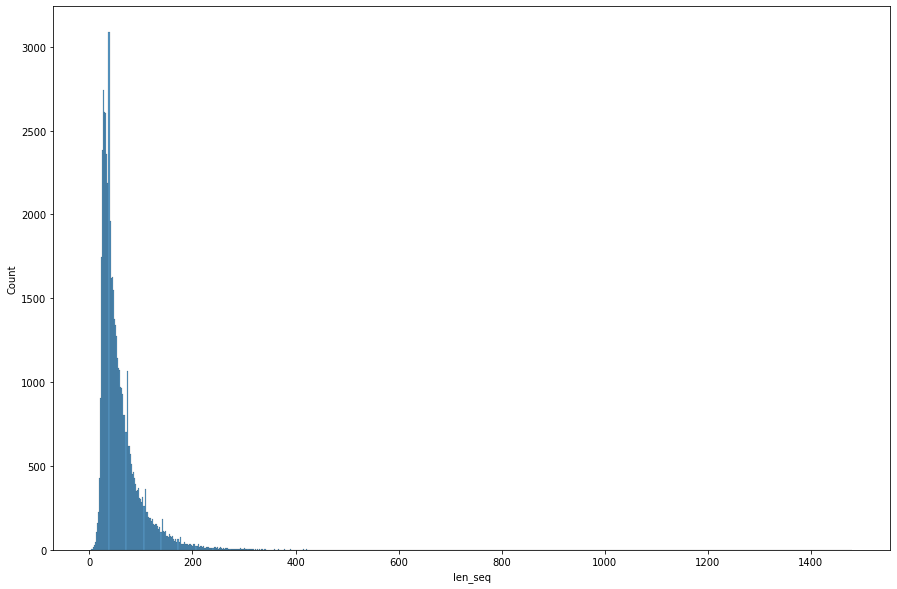

In [18]:
# Построим распределение
plt.rcParams['figure.figsize'] = (15,10)
sns.histplot(main_df.len_seq)

Как видим, большинство описаний имеют длину менее 200 слов

In [19]:
max_len = np.max([len(list_) for list_ in main_df.description_encoded.values])
print(f"максимальная длина последовательности: {max_len}")

максимальная длина последовательности: 1481


Поскольку длина последовательности сильно скащывается на времени обучения, ограничимся длиной 200

In [20]:
SEQ_LEN=200

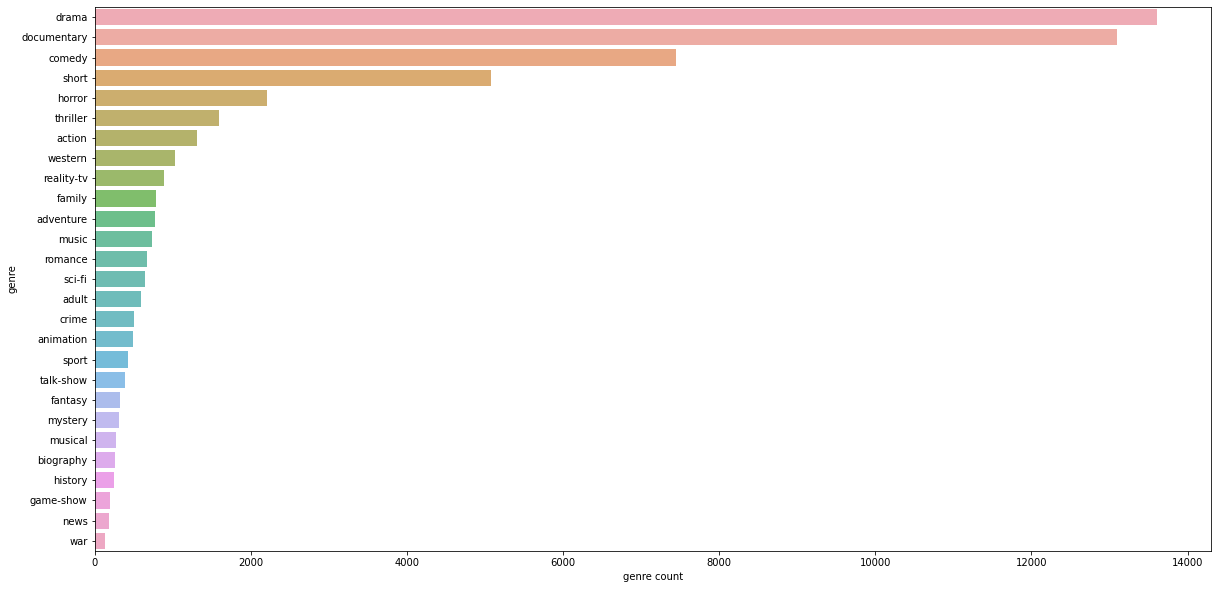

In [39]:
# Также построим распределение целевой переменной
plt.rcParams['figure.figsize'] = (20,10)
data = main_df.groupby(by='genre', as_index=False, ).count().sort_values(by='films_name', ascending=False)
ax = sns.barplot(data=data, y='genre', x='films_name', alpha=0.8)
ax.set_xlabel('genre count')
plt.show()

Как видим данные сильно не сбалансированы, и из 27 жанров явно выделяются драма, комендия, документальный и short. Также можно добавить к рассмотрению такие жанры как horror, thriller, crime, action поскольку описания подобных фильмов скорее всего будут похожи. Остальные фильмы на данном этапе объеденим в жанр others. После построения модели для выбранных жанров необходимо будет провести исследования для оставшихся

Кол-во фильмов популярных жанров: 45371
Кол-во фильмов непопулярных жанров: 8843


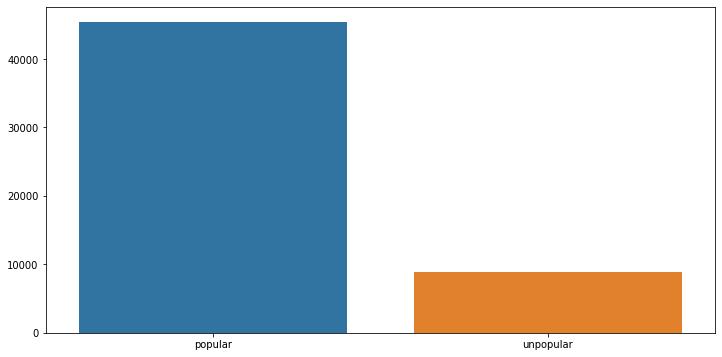

In [53]:
popular_genres = ['drama', 'documentary', 'comedy', 'short', 'horror', 'thriller', 'action', 'western']
popular_count = main_df[main_df.genre.isin(popular_genres)].shape[0]
unpopular_count = main_df[~main_df.genre.isin(popular_genres)].shape[0]
print(f'Кол-во фильмов популярных жанров: {popular_count}\nКол-во фильмов непопулярных жанров: {unpopular_count}')
plt.rcParams['figure.figsize'] = (12,6)
sns.barplot(x=['popular', 'unpopular'], y=[popular_count, unpopular_count])
plt.show()

Как видно из графика выбранные жанры охватывают большее число отзывов

In [66]:
# Препобразуем остальные жанры в тип other
popular_genres_df = main_df.copy(deep=True)
popular_genres_df['genre'] = popular_genres_df['genre'].apply(lambda x: x if x in popular_genres else 'other')
popular_genres_test_df = test_df.copy(deep=True)
popular_genres_test_df['genre'] = test_df['genre'].apply(lambda x: x if x in popular_genres else 'other')
popular_genres_df.head(5)

,films_name,genre,description,description_tokenized,description_encoded,genre_numeric,len_seq
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,"[listening, conversation, doctor, parents, 10-...","[16800, 85997, 6785, 0, 0, 18033, 88388, 10705...",8,51
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...,"[brother, sister, past, incestuous, relationsh...","[102674, 21201, 65184, 19616, 32633, 8522, 832...",24,15
2,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fiel...,"[bus, empties, students, field, trip, museum, ...","[102035, 0, 0, 33916, 92641, 75453, 101698, 74...",1,60
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,"[help, unemployed, father, make, ends, meet, e...","[28913, 74515, 20781, 58934, 0, 101227, 104912...",8,109
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,"[film, 's, title, refers, un-recovered, bodies...","[50128, 0, 50619, 45583, 0, 0, 88473, 98157, 6...",8,58


In [67]:
# Также необходимо изменить численные значения жанров фильмов
popular_genres_df.drop(columns=['genre_numeric'])
popular_genres_test_df.drop(columns=['genre_numeric'])
popular_genres_df['genre_numeric'], genres = pd.factorize(popular_genres_df['genre'], sort=True)
popular_genres_test_df['genre_numeric'], test_genres =  pd.factorize(popular_genres_test_df['genre'], sort=True)
#Проверяем что жанры их тренировочного и тестового набора соответствуют друг другу
test_genres == genres

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [69]:
# Подготовим тестовые и тренировочные наборы, выбранное значение длины последовательности слов на данные момент составляет 200
train_data = tf.keras.preprocessing.sequence.pad_sequences(popular_generes_df.description_encoded.values, 
                                                           value=vocab["<PAD>"],
                                                           padding='post',
                                                           maxlen=SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(popular_genres_test_df.description_encoded.values, 
                                                          value=vocab["<PAD>"],
                                                          padding='post',
                                                          maxlen=SEQ_LEN)

In [70]:
# Увеличиваем размер словаря на 1, т.к. мы добавили туда значение паддинга
VOCAB_SIZE = np.max(list(vocab.values()))+1
VOCAB_SIZE

107607

In [80]:
# В качестве первой модели рассмотрим двунаправленную LSTM. Поскольку модели
# RNN склонны к переобучению добавим регуляризацию с помощью дропаутов 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 128),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(len(genres)),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         13773696  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        788480    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 15,220,873
Trainable params: 15,220,873
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [73]:
#подключаем диск для сохранения модели
drive.mount('/gdrive')

Mounted at /gdrive


In [83]:
# Задаем параметры обучения, а также создаем чекпоинт для сохранения модели
BATCH_SIZE = 256
NUM_EPOCHS = 10

checkpoint_path = "/gdrive/MyDrive/RNN_model/cp_simple_lstm.ckpt"


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

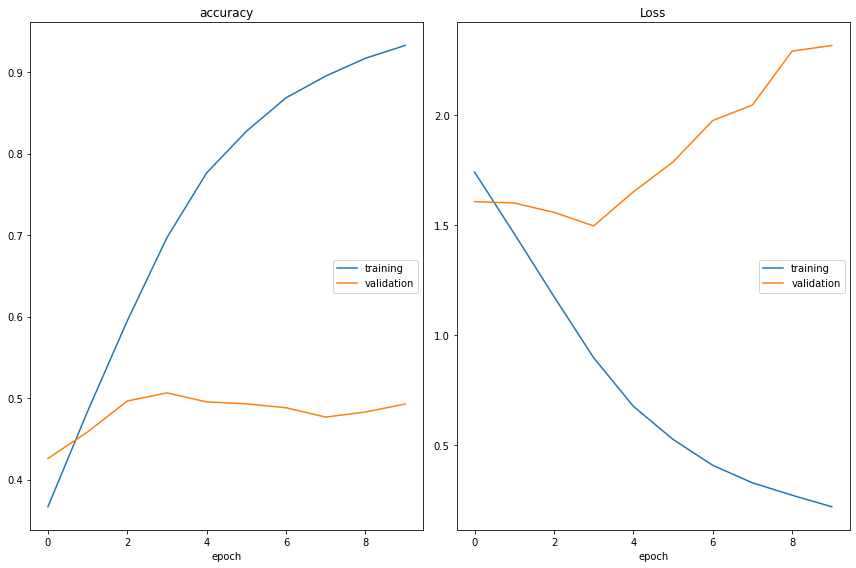

accuracy
	training         	 (min:    0.367, max:    0.933, cur:    0.933)
	validation       	 (min:    0.426, max:    0.506, cur:    0.493)
Loss
	training         	 (min:    0.221, max:    1.741, cur:    0.221)
	validation       	 (min:    1.497, max:    2.317, cur:    2.317)

Epoch 10: saving model to /gdrive/MyDrive/RNN_model/cp_simple_lstm.ckpt
128/128 [==============================] - 433s 3s/step - loss: 0.2205 - accuracy: 0.9326 - val_loss: 2.3170 - val_accuracy: 0.4926


In [84]:
history = model.fit(
    x=train_data,
    y=popular_genres_df['genre_numeric'],
    batch_size=BATCH_SIZE,
    callbacks=[PlotLossesKeras(), cp_callback],
    validation_split = 0.4, 
    epochs=NUM_EPOCHS)

Как видим данная модель показывает всего лишь 49% процентов точности, следовательно нужно либо усложнить модель, либо использовать более сложный подход при переходе от описаний фильмов к численному представлению

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
checkpoint_path = "/gdrive/MyDrive/RNN_model/cp_simple_lstm.ckpt"
import os
os.chdir('/gdrive')
VOCAB_SIZE = 107607
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(VOCAB_SIZE, 64),
                            tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
                            tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
                            tf.keras.layers.Dense(27),
                             ])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.load_weights(checkpoint_path)
# model = tf.keras.models.load_model('/MyDrive/RNN_model/cp.ckpt')

In [ ]:
loss, acc = model.evaluate(test_data, 
                           test_df.genre_numeric.values, 
                           verbose=2,
                           batch_size=256)
print("accuracy: {:5.2f}%".format(100 * acc))

212/212 - 498s - loss: 6.3244 - accuracy: 0.1811 - 498s/epoch - 2s/step
accuracy: 18.11%


Таким образом не смотря на точность в 90% на обучающей выборке при обучении и порядка 50% на валидационной, точность на тестовой выборке составляет всего лишь 20%. Таким образом можно сделать вывод, что для данной модели нужна более глубокая модель, а также бОльшая регуляризация.